In [1]:
import sys
packages = [
    '../../dataset/',
    '../../utils/',
    '../../optimizer/',
    '../../loss/',
    '../../model/'
]
sys.path.extend(packages)
from sklearn.model_selection import KFold
from tqdm import tqdm
from brpnet.model import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from dataset.PathologyData import PathologyDataSet
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from postProcess.post_proc import post_proc,getInstancePosition
# 首先先对图片进行染色归一化处理
from StainProcess.StainNormalization import normalizeStaining
from ImageProcess.ImageProcess import cv2Bgr2Rgb
from DataUtil import kfold_list
from util import getNowTime,transformImg,extract_patches,reconstruct_from_patches_weightedall,test_extract_patches
from metrics import get_fast_aji,remap_label
from scipy import ndimage
from skimage.morphology import label
import scipy.io as scio



In [2]:
from torch.utils.data import Dataset,DataLoader
#获取所有的Instance的数据
def getAllInstanceData():
    testSameImg = np.load('../../dataset/kumarDataset/train/testSameDataSet.npy')
    gts = np.load('../../dataset/kumarDataset/labels/labelSameDataSet.npy')
    souts = []
    couts = []
    preds = []
    for i in range(0,8):
        pred = np.load(f'val_{i}_pred.npz')
        souts.append(pred['sout'])
        couts.append(pred['cout'])
        preds.append(pred['pred'])
    return testSameImg,souts,couts,preds,gts

# InstanceDataSet
class InstanceDataSet(Dataset):
    def __init__(self,trainImages,souts,couts,preds,labelImages):
        super(InstanceDataSet,self).__init__()
        self.trainImages = trainImages
        self.souts = souts
        self.couts = couts
        self.preds = preds
        self.labelImages = labelImages
        self.instancesMap = {}
        self.instanceNum = []
        # 初始化所有的细胞所在的框
        imgCount = 0
        for index,labelImage in enumerate(self.labelImages):
            instances = getInstancePosition(labelImage)
            # imgCount记录的是累加的细胞的数量，从第一个数量开始累加
            imgCount += instances.shape[0]
            self.instancesMap[index] = instances
            self.instanceNum.append(imgCount)

    def __len__(self):
        # instanceNum最后一个数字代表的就是instance的总数
        return self.instanceNum[len(self.instanceNum)-1]

    def reLocation(self,x,y,h,w):
        # 全部转换成偶数
        h = h if h%2 == 0 else h+1
        w = w if w%2 == 0 else w+1
        if h == w:
            h,w = h+24,w+24
            x = x-12 if x-12 >= 0 else 0
            y = y-12 if y-12 >= 0 else 0
        if h > w:
            h = h+24
            x = x-(h-w)//2 if x-(h-w)//2 >= 0 else 0
            y = y-12 if y-12 >= 0 else 0
        if h < w:
            w = w+24
            y = y-(w-h)//2 if y-(w-h)//2 >=0 else 0
            x = x-12 if x-12 >= 0 else 0
        return x,y,max(h,w),max(h,w)

    def __getitem__(self,idx):
        # 这边需要注意取值为0的问题
        for index,num in enumerate(self.instanceNum):# [397, 836, 1192, 1550, 1843, 2220, 2548, 3019]
            if idx <= num:
                lastMax = 0
                if index == 0:
                    lastMax = 0
                else:
                    lastMax = self.instanceNum[index-1]
                InsPoi = self.instancesMap[index][idx-lastMax-1]
                print('InsPoi:',InsPoi)
                # 返回图片的数据每个边距离边缘最小也要有12pixel大小,最后扩充成一个正方形
                x,y,h,w = InsPoi[0],InsPoi[1],InsPoi[2],InsPoi[3]
                # 数据有点问题的直接跳过
                if x == 0 and y == 0 and h == 0 and w ==0:
                    return None,None,None,None,None
                xr,yr,hr,wr = self.reLocation(x,y,h,w)
                # 如何扩充成正方形，并且最小的margin也要有12
                #-------------------------------------------------------------------------------------------------------------------------------------------#
                y1 = yr
                y2 = yr + hr if yr + hr < 1000 else 1000
                x1 = xr
                x2 = xr + wr if xr + wr < 1000 else 1000
                # 获取图片
                trainImage_ins = self.trainImages[index][y1:y2,x1:x2]
                # 获取语义分割的结果
                sout_ins = self.souts[index][y1:y2,x1:x2] 
                # 获取边界分割的结果
                cout_ins = self.couts[index][y1:y2,x1:x2]
                # 获取输出值的结果
                pred_ins = self.preds[index][y1:y2,x1:x2]
                pred_ins[pred_ins != 0] = 1
                pred_ins = pred_ins.astype('uint8')
                # 获取标签的结果
                label_ins = self.labelImages[index][y1:y2,x1:x2]
                label_ins[label_ins != 0] = 1
                label_ins = label_ins.astype('uint8')
                # print('index: ',index,'idx-lastMax:',idx-lastMax,'init shape: ',x,y,h,w,'shape: ',xr,yr,hr,wr)
                return trainImage_ins,sout_ins,cout_ins,pred_ins,label_ins
# 获取全部的数据
testSameImg,souts,couts,preds,gts = getAllInstanceData()



In [3]:
instanceDataSet = InstanceDataSet(testSameImg,souts,couts,preds,gts)


InsPoi: [256 483  40  32]


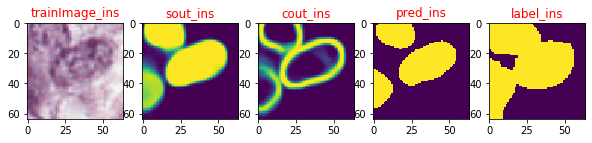

In [4]:
trainImage_ins,sout_ins,cout_ins,pred_ins,label_ins = instanceDataSet[500]
showLineImg([trainImage_ins,sout_ins,cout_ins,pred_ins,label_ins],title=['trainImage_ins','sout_ins','cout_ins','pred_ins','label_ins'])



(1, 1, 64, 64)


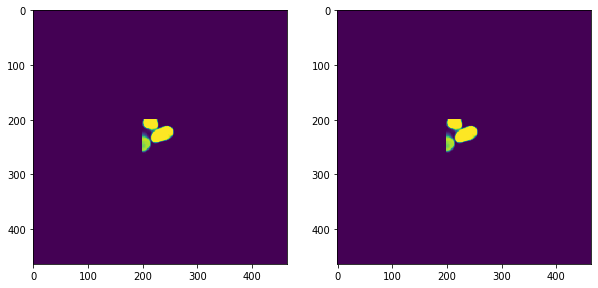

In [17]:
sout_ins_pad = np.expand_dims(sout_ins,axis=0)
sout_ins_pad_pad = np.expand_dims(sout_ins_pad,axis=0)
print(sout_ins_pad_pad.shape)

img = np.pad(sout_ins,((200,200),(200,200)),'constant',constant_values=0)
showLineImg([img,img])




In [18]:
###############################################
print(img.shape)













(464, 464)


In [9]:


size48_train = []
size48_sout_ins = []
size48_cout_ins = []
size48_pred_ins = []
size48_label_ins = []

size176_train = []
size176_sout_ins = []
size176_cout_ins = []
size176_pred_ins = []
size176_label_ins = []


for i in range(len(instanceDataSet)):
    trainImage_ins,sout_ins,cout_ins,pred_ins,label_ins = instanceDataSet[i]
    if label_ins is not None:
        if label_ins.shape[0] <= 48:
            size48_train.append(cv2.resize(trainImage_ins,(48,48)))
            size48_sout_ins.append(cv2.resize(sout_ins,(48,48)))
            size48_cout_ins.append(cv2.resize(cout_ins,(48,48)))
            size48_pred_ins.append(cv2.resize(pred_ins,(48,48)))
            size48_label_ins.append(cv2.resize(label_ins,(48,48)))
        else:
            size176_train.append(cv2.resize(trainImage_ins,(176,176)))
            size176_sout_ins.append(cv2.resize(sout_ins,(176,176)))
            size176_cout_ins.append(cv2.resize(cout_ins,(176,176)))
            size176_pred_ins.append(cv2.resize(pred_ins,(176,176)))
            size176_label_ins.append(cv2.resize(label_ins,(176,176)))

# 48
size48_train_npy = np.array(size48_train)
size48_sout_ins_npy = np.array(size48_sout_ins)
size48_cout_ins_npy = np.array(size48_cout_ins)
size48_pred_ins_npy = np.array(size48_pred_ins)
size48_label_ins_npy = np.array(size48_label_ins)

# 176
size176_train_npy = np.array(size176_train)
size176_sout_ins_npy = np.array(size176_sout_ins)
size176_cout_ins_npy = np.array(size176_cout_ins)
size176_pred_ins_npy = np.array(size176_pred_ins)
size176_label_ins_npy = np.array(size176_label_ins)

np.save('../../patchNet/size48/size48_train_npy.npy',size48_train_npy)
np.save('../../patchNet/size48/size48_sout_ins_npy.npy',size48_sout_ins_npy)
np.save('../../patchNet/size48/size48_cout_ins_npy.npy',size48_cout_ins_npy)
np.save('../../patchNet/size48/size48_pred_ins_npy.npy',size48_pred_ins_npy)
np.save('../../patchNet/size48/size48_label_ins_npy.npy',size48_label_ins_npy)


np.save('../../patchNet/size176/size176_train_npy.npy',size176_train_npy)
np.save('../../patchNet/size176/size176_sout_ins_npy.npy',size176_sout_ins_npy)
np.save('../../patchNet/size176/size176_cout_ins_npy.npy',size176_cout_ins_npy)
np.save('../../patchNet/size176/size176_pred_ins_npy.npy',size176_pred_ins_npy)
np.save('../../patchNet/size176/size176_label_ins_npy.npy',size176_label_ins_npy)




InsPoi: [596 290  42  36]
InsPoi: [114  96  14  22]
InsPoi: [ 49 307   8  21]
InsPoi: [  0 344  17  19]
InsPoi: [953 217  13  12]
InsPoi: [239 288  17  13]
InsPoi: [ 47 425  10  13]
InsPoi: [759 237  19  16]
InsPoi: [711 236  16  11]
InsPoi: [760 247  19  21]
InsPoi: [444 163  19  16]
InsPoi: [ 33 671   6   7]
InsPoi: [120 205  16  21]
InsPoi: [ 23 668   8   5]
InsPoi: [ 45 665  15  17]
InsPoi: [185 401  22  22]
InsPoi: [108 670  21  12]
InsPoi: [303 749  16  10]
InsPoi: [  0 652   8   8]
InsPoi: [ 46 633  15  22]
InsPoi: [ 97 735  18  16]
InsPoi: [ 70 637  18  18]
InsPoi: [ 87 898  16  12]
InsPoi: [  0 502   9  14]
InsPoi: [698 986  16  14]
InsPoi: [ 11 723  21  19]
InsPoi: [757 350  20  23]
InsPoi: [831 425   8  13]
InsPoi: [879 883  21  14]
InsPoi: [975 865  18  18]
InsPoi: [923 628  12  11]
InsPoi: [ 30 660  10   9]
InsPoi: [  1 624   6  15]
InsPoi: [618 846  12  16]
InsPoi: [322 995   9   5]
InsPoi: [819 850  18  18]
InsPoi: [236 647  18  15]
InsPoi: [278 755  19  17]
InsPoi: [914